In [184]:
# Import the relevant python libraries for the analysis
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import histogram
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import pylab as pl
import math

In [185]:
# Load the dataset
materna = pd.read_csv('mortalidad_materna.csv')
#materna.info()

In [186]:
# Create a variable to hold all Region Names for reference
residence = materna['Descripción de entidad de residencia']
residence = np.unique(residence)

## Question: Are the differences in Average Age and Distribution of Age of Maternal Death Across Mexico's States/Providences Statistically Significant?

A One-Way Analysis of Variance (ANOVA) test compares the means of two or more groups to determine if at least one group mean is statistically different from the others. These assumptions that must be satisfied in order for the associated p-value to be valid:

1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. (homoscedasticity)

### Step 1: Explore the Data and Create Clean Sub-Dataframe for Analysis

In [187]:
# Create variables for Region and Last Recorded Age from materna
residence = materna['Descripción de entidad de residencia']
last_age = materna['Edad cumplida']

# Create variable for Birth and Reason for Mortality in order to remove non-maternal deaths from subset
birth = materna['Año de nacimiento']
mortality_reason = materna['Razón de mortalidad materna']

# Create a subdataset with Region and Last Recorded Age from materna
region_ages = pd.concat([residence, last_age, birth, mortality_reason], axis=1)
region_ages.columns = ['Region', 'Age of Maternal Death', 'Year of Birth', 'Mortality Reason']
region_ages = region_ages.sort_values(by=['Age of Maternal Death'],ascending=False)
region_ages.head()

,Region,Age of Maternal Death,Year of Birth,Mortality Reason
16080,Guerrero,998,0,1
17886,No especificado,998,0,0
13358,Chihuahua,998,0,1
17887,Puebla,998,0,0
14622,Tamaulipas,998,0,1


In [188]:
# Remove irregular values in similar manner to materna_mean_age Jupyter Notebook 

#Remove rows with 0 values in Year of Birth
region_ages = region_ages[region_ages['Year of Birth'] != 0]

#Remove rows with 0 values in Mortality Reason
region_ages = region_ages[region_ages['Mortality Reason'] != 0 ]
region_ages.head()

,Region,Age of Maternal Death,Year of Birth,Mortality Reason
14960,Oaxaca,54,1942,1
9964,Chiapas,53,1961,1
7705,México,53,1963,1
16722,Guerrero,51,1960,1
15461,Distrito Federal,50,1960,1


In [189]:
# Remove Year of Birth and Mortality Reason columns as they are no longer necessary
region_ages = region_ages.drop(['Year of Birth', 'Mortality Reason'], axis=1)
region_ages.head()

,Region,Age of Maternal Death
14960,Oaxaca,54
9964,Chiapas,53
7705,México,53
16722,Guerrero,51
15461,Distrito Federal,50


In [190]:
# Put region_ages in alphabetical order by Region
region_ages = region_ages.sort_values(by=['Region'],ascending=True)
region_ages.head()

,Region,Age of Maternal Death
2614,Aguascalientes,28
2799,Aguascalientes,35
2735,Aguascalientes,30
2460,Aguascalientes,19
2515,Aguascalientes,28


In [191]:
print('There are '+ str(len(np.unique(region_ages['Region']))) + ' Provinces in Mexico.')
list(np.unique(region_ages['Region']))

There are 34 Provinces in Mexico.


['Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Coahuila de Zaragoza',
 'Colima',
 'Distrito Federal',
 'Durango',
 'Estados Unidos de Norteamérica',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Michoacán de Ocampo',
 'Morelos',
 'México',
 'Nayarit',
 'Nuevo León',
 'Oaxaca',
 'Otros paises latinoamericanos',
 'Puebla',
 'Querétaro Arteaga',
 'Quintana Roo',
 'San Luis Potosí',
 'Sinaloa',
 'Sonora',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz de Ignacio de la Llave',
 'Yucatán',
 'Zacatecas']

#### Additional Cleaning of Database: 
There are 31 states and 1 federal entity in Mexico, so the length of the 'Regions' column should be 32, not 34. When translating the list of regions within the sub-dataset, it becomes apparent that not all entries are Provinces within Mexico, and need to be removed. Nameley:
- Estados Unidos de Norteamérica - 'United States of America'
- Otros paises latinoamericanos - 'Other Latin American countries'

In [192]:
# Remove unnecessary columns from region_ages sub-dataset
region_ages = region_ages[region_ages['Region'] != 'Estados Unidos de Norteamérica' ]
region_ages = region_ages[region_ages['Region'] != 'Otros paises latinoamericanos' ]
print('There are '+ str(len(np.unique(region_ages['Region']))) + ' Provinces in Mexico.')
list(np.unique(region_ages['Region']))

There are 32 Provinces in Mexico.


['Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Coahuila de Zaragoza',
 'Colima',
 'Distrito Federal',
 'Durango',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Michoacán de Ocampo',
 'Morelos',
 'México',
 'Nayarit',
 'Nuevo León',
 'Oaxaca',
 'Puebla',
 'Querétaro Arteaga',
 'Quintana Roo',
 'San Luis Potosí',
 'Sinaloa',
 'Sonora',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz de Ignacio de la Llave',
 'Yucatán',
 'Zacatecas']

### Step 2: Prepare the Data for Analysis

In [195]:
# Create a sample region array variables to hold age distribution per region 
# as a model to construct a function to parse through subdataset, region_ages
aqua = region_ages[region_ages['Region'] == 'Aguascalientes']
aqua = aqua['Age of Maternal Death']
aqua = np.array(aqua)

mex = region_ages[region_ages['Region'] == 'México']
mex = mex['Age of Maternal Death']
mex = np.array(mex)

print('Aguascalientes Sample Length: ' + str(len(aqua)))
print('México Sample Length: ' + str(len(mex)))

Aguascalientes Sample Length: 127
México Sample Length: 2299


Since it appears that the sample size of ages of maternal death within the Provinces varies, the total sample per Province should be stored in unique age array variables. The process of creating the age array is repeatable, so a function should be created then applied to each Province. The array of ages variable can then be stored in a dictionary as a value with the associated Province as the key.

In [196]:
# Create a function to group all ages associated with materna death within a Province and store the ages in an array

def age_array(str):
    """Create arrays for all Ages of Maternal Death within a Region"""
    
    # Select the region 'str' from the 'Region' column
    ages = region_ages[region_ages['Region'] == str]
    
    # Select the ages within the region
    ages = ages['Age of Maternal Death'] 
    
    # Store the ages in an array
    ages = np.array(ages)
    
    # return the unique array
    return ages

In [205]:
# Create a variable for 'Region' names using np.unique()
list_regions = np.unique(region_ages['Region'])

# Create an empty dictionary to hold the {Region : region_age_array} key pairs
age_by_state = {}

In [206]:
# Use the age_array function with iteration over residence to create the {Region : region_age_array} key pairs
for region in list_regions:
    
    # Add arrays as values in dictionary with region-key
    age_by_state[region] = age_array(region)

In [208]:
age_by_state

{'Aguascalientes': array([28, 35, 30, 19, 28, 33, 33, 18, 34, 24, 22, 18, 36, 31, 31, 33, 21,
        38, 19, 19, 23, 24, 16, 28, 20, 42, 31, 29, 29, 25, 29, 33, 20, 26,
        26, 35, 18, 32, 33, 19, 24, 20, 30, 27, 30, 36, 25, 21, 37, 28, 36,
        35, 35, 35, 35, 15, 21, 15, 31, 23, 17, 17, 25, 17, 17, 17, 41, 38,
        16, 23, 40, 43, 32, 35, 22, 36, 22, 18, 17, 35, 36, 30, 25, 39, 39,
        31, 40, 32, 30, 31, 20, 29, 23, 35, 37, 22, 42, 25, 33, 29, 39, 23,
        32, 26, 27, 39, 23, 31, 34, 25, 43, 22, 29, 42, 34, 28, 39, 22, 30,
        27, 21, 20, 37, 20, 38, 28, 20]),
 'Baja California': array([36, 35, 17, 25, 31, 26, 17, 28, 22, 24, 31, 17, 31, 24, 23, 31, 19,
        21, 33, 31, 17, 30, 38, 34, 22, 34, 24, 33, 22, 31, 31, 27, 37, 24,
        25, 26, 21, 36, 41, 36, 29, 25, 17, 23, 23, 28, 25, 32, 33, 20, 21,
        34, 29, 29, 36, 23, 36, 17, 17, 32, 38, 17, 25, 17, 23, 28, 20, 17,
        20, 32, 22, 22, 19, 27, 21, 16, 28, 31, 33, 37, 27, 25, 36, 34, 25,
        2

### Step 3: Begin Proof for ANOVA Examination

#### 1. Samples must be Random / Independent

In [241]:
# Calculate the total sample size / length of materna death 
total_sample_length = len(region_ages['Age of Maternal Death'])
total_sample_length

16631

Using the data provided by the National Institute of Statistics, Geography, and Data Processing's visualization of populations within the 32 Mexican Provinces, it can be determined that the *smallest population* within a Mexican province is > 500,000 people. 

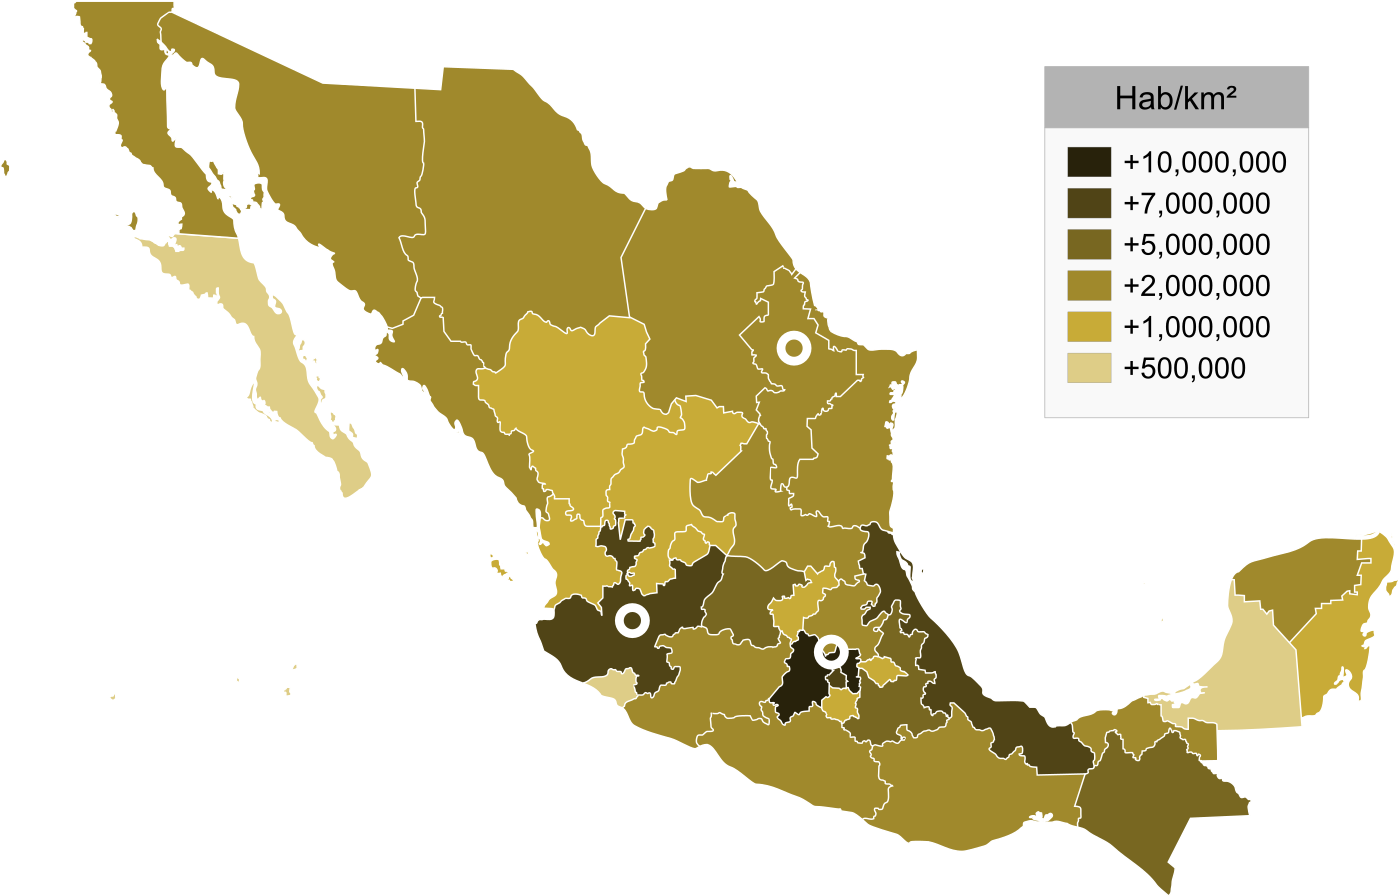


Therefore, we can use the **10% Rule** justify treating each incidence of maternal death as an independent event so long as the sample population size is < 50,000. Since the total length of the cleaned region_ages dataset is n=16631, the length of each Province sample size is well under 50,000. Thus, **the samples can be treated as independent**.

#### 2. Samples must be Normally Distributed

Within the SciPy module of python 3, there is a normalcy function that tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality. This function will be used to determine if the distribution of each Province sample population is normally distributed or not.

In [242]:
# Create a variable to hold list of Regions with normally-distributed sample sizes
regions_for_stats_analysis = []

# Create a variable to hold list of Regions without normally-distributed sample sizes
regions_not_for_stats_analysis = []

In [243]:
# Determine if each Province has a normally distributed sample population of ages

for region in age_by_state:
    
    # Select age array by Region key in database
    region_name = str(region)
    arr = age_by_state[region]
    
    # Skewtest (k2) is not valid with less than 8 samples
    if len(arr) > 8:
        
        # Test for normalcy of distribution (with Skewtest)   
        k2, p = stats.normaltest(arr)

        # Set significance level to 95% confidence
        alpha = 0.05
        print("p = {:g}".format(p))
        print("n = " + str(len(arr)))

        # Print result for each region normalcy test
        if p < alpha:  # null hypothesis: x comes from a normal distribution
            print(str(region)+ " IS normally distributed.")
            
            # Add region to list of regions for statistical analysis
            regions_for_stats_analysis.append(region_name)
            
        else:
            print(str(region)+ " *IS NOT* normally distributed.")
              
            # Add region to list of regions NOT for statistical analysis
            regions_not_for_stats_analysis.append(region_name)
                
    else: 
        print(str(region)+ " *sample size is too small*")
        
        # Add region to list of regions NOT for statistical analysis
        regions_not_for_stats_analysis.append(region_name)

p = 8.92987e-06
n = 127
Aguascalientes IS normally distributed.
p = 9.69442e-10
n = 361
Baja California IS normally distributed.
p = 0.00564503
n = 66
Baja California Sur IS normally distributed.
p = 0.00137276
n = 126
Campeche IS normally distributed.
p = 1.03976e-37
n = 1235
Chiapas IS normally distributed.
p = 8.42917e-19
n = 628
Chihuahua IS normally distributed.
p = 1.6423e-09
n = 310
Coahuila de Zaragoza IS normally distributed.
p = 0.788087
n = 49
Colima *IS NOT* normally distributed.
p = 2.13913e-21
n = 1082
Distrito Federal IS normally distributed.
p = 8.83805e-06
n = 263
Durango IS normally distributed.
p = 6.25818e-14
n = 707
Guanajuato IS normally distributed.
p = 6.26788e-20
n = 977
Guerrero IS normally distributed.
p = 1.22187e-06
n = 428
Hidalgo IS normally distributed.
p = 3.85647e-24
n = 802
Jalisco IS normally distributed.
p = 3.0739e-14
n = 654
Michoacán de Ocampo IS normally distributed.
p = 1.07763e-05
n = 243
Morelos IS normally distributed.
p = 1.9078e-37
n = 229

In [244]:
list(np.unique(regions_for_stats_analysis))

['Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Coahuila de Zaragoza',
 'Distrito Federal',
 'Durango',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Michoacán de Ocampo',
 'Morelos',
 'México',
 'Nayarit',
 'Nuevo León',
 'Oaxaca',
 'Puebla',
 'Querétaro Arteaga',
 'San Luis Potosí',
 'Sinaloa',
 'Sonora',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz de Ignacio de la Llave',
 'Yucatán',
 'Zacatecas']

In [237]:
list(np.unique(regions_not_for_stats_analysis))

['Colima', 'Quintana Roo']

**Conclusion**: After assessing the distribution of age of maternal death within each Province of Mexico, **almost all Province sample populations are considered to be normally distributed** *aside from* Colima (p-value: 2.13913e-21, n=1082) Quintana Roo (p-value: 0.00022599, n=375), which were found to *not be normally distributed*.

However, under the Central Limit Theorem (CLT), the sampling distribution of the sample means approaches a normal distribution as the sample size ( n ) gets larger - regardless of what the shape of the population distribution. Under this theorem,  n>30  is considered a large sample size. *Since the current database sample size (n) of Colima and Quintana Roo of 1082 and 375, respectively, justify CLT being assumed.* 


## One-Way Analysis of Variance

$H$o: All mean age of death of maternal women within all Province of Mexico are statistically similar. <br>  Empirical Mean ($μ$) − Population Mean ($μ$) = 0

$H$a: There is at least one mean age of death of maternal women within a Province of Mexico that is statistically different from the rest. <br> Empirical Mean ($μ$) − Population Mean ($μ$) ≠ 0

Significance Level: *95%* Confidence. <br> $α$ = 0.05